Lets now look into language.

Some of the examples are from [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). 

## How do we deal with language?

In [4]:
!pip install regex

In [5]:
import regex as re

def split_chars(text):
    return re.findall(r".", text)

In [6]:
chars = split_chars("I love computer science it is so much fun")
chars[:12]

['I', ' ', 'l', 'o', 'v', 'e', ' ', 'c', 'o', 'm', 'p', 'u']

In [7]:
def split_words(text):
    return re.findall(r"[\w]+|[.,!?;]", text)

split_words("I love computer science it is so much fun")

['I', 'love', 'computer', 'science', 'it', 'is', 'so', 'much', 'fun']

In [8]:
vocabulary = { 
    "UNK": 0,
    "I": 1,
    "love": 2,
    "computer": 3,
    "science": 4,
    "it": 5,
    "is": 6,
    "so": 7,
    "much": 8,
    "fun": 9,
}

In [9]:
words = split_words("I love computer science it is so much fun and games and more fun")
indices = [vocabulary.get(word, 0) for word in words]
indices

[1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 0, 0, 0, 9]

This is what is called Tokenizer. We can create tokens from words making them numerical.

**Problems with Tokenization**

Character-level tokenization

- Very small vocabulary (e.g., ~64 symbols)  
- Produces very long input sequences  
- Long sequences increase computational cost  
- Harder for models to capture long-range dependencies  

Word-level tokenization

- Produces much shorter sequences (efficient “compression”)  
- Vocabulary grows extremely large for real-world datasets  
- Large-scale corpora may require millions of unique tokens  
- Restricting vocabulary size leads to many "[UNK]" tokens  
- "[UNK]" tokens discard useful semantic information  

General scaling problem

- Modern datasets contain billions or trillions of words  
- Pure word-level vocabularies become impractical  
- Pure character-level models become inefficient  

Motivation for subword tokenization

Subword tokenization attempts to:

- Reduce vocabulary size  
- Avoid excessive "[UNK]" tokens  
- Maintain manageable sequence length  
- Balance efficiency and expressiveness  

In [10]:
class CharTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r".", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [11]:
import collections

def compute_char_vocabulary(inputs, max_size):
    char_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r".", x)
        char_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = char_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [12]:
class WordTokenizer:
    def __init__(self, vocabulary):
        self.vocabulary = vocabulary
        self.unk_id = vocabulary["[UNK]"]

    def standardize(self, inputs):
        return inputs.lower()

    def split(self, inputs):
        return re.findall(r"[\w]+|[.,!?;]", inputs)

    def index(self, tokens):
        return [self.vocabulary.get(t, self.unk_id) for t in tokens]

    def __call__(self, inputs):
        inputs = self.standardize(inputs)
        tokens = self.split(inputs)
        indices = self.index(tokens)
        return indices

In [13]:
def compute_word_vocabulary(inputs, max_size):
    word_counts = collections.Counter()
    for x in inputs:
        x = x.lower()
        tokens = re.findall(r"[\w]+|[.,!?;]", x)
        word_counts.update(tokens)
    vocabulary = ["[UNK]"]
    most_common = word_counts.most_common(max_size - len(vocabulary))
    for token, count in most_common:
        vocabulary.append(token)
    return dict((token, i) for i, token in enumerate(vocabulary))

In [14]:
import keras

filename = keras.utils.get_file(
    origin="https://www.gutenberg.org/cache/epub/9109/pg9109.txt",
)
moby_dick = list(open(filename, "r", encoding="utf-8"))

vocabulary_char = compute_char_vocabulary(moby_dick, max_size=100)
char_tokenizer = CharTokenizer(vocabulary_char)

In [15]:
len(vocabulary_char)

90

In [16]:
print("Vocabulary end:", list(vocabulary_char.keys())[-10:])

Vocabulary end: ['ß', '©', '£', '\x8d', 'ú', '°', '±', '`', 'ä', '‘']


In [17]:
vocabulary_word = compute_word_vocabulary(moby_dick, max_size=2000)
word_tokenizer = WordTokenizer(vocabulary_word)

In [18]:
len(vocabulary_word)

2000

In [19]:
print("Vocabulary end:", list(vocabulary_word.keys())[-10:])

Vocabulary end: ['relevant', 'signal', 'mary', 'aware', 'phrase', 'increased', 'june', 'ellipsis', 'opinions', 'vs']


Subword tokenization is a compromise between word-level and character-level tokenization. Instead of splitting text strictly into full words or single characters, it breaks words into frequently occurring subunits. 

Subword tokenization is a compromise between word-level and character-level tokenization.  
Instead of splitting text strictly into full words or single characters, it breaks words into frequently occurring subunits.

For example:

- Character-level tokenization of **"playing"**:
  p, l, a, y, i, n, g  
  (long sequence, but very small vocabulary)

- Word-level tokenization of **"playing"**:
  playing  
  (short sequence, but requires "playing" to exist in the vocabulary)

- Subword tokenization of **"playing"**:
  play, ing  

Another example:

- Word-level tokenization of **"neurobiologist"** might produce:
  [UNK]  
  if the word is not in the vocabulary.

- Subword tokenization might produce:
  neuro, bio, logist  

This preserves meaningful parts of the word and avoids losing information.

Subword methods (such as Byte Pair Encoding or WordPiece) work by identifying frequently occurring character combinations and merging them into tokens. Over time, common word fragments become stable units, while rare words are decomposed into smaller known pieces.

This approach provides:

- A manageable vocabulary size  
- Shorter sequences than character-level tokenization  
- Fewer unknown tokens than word-level tokenization  

Modern large language models (e.g., BERT, GPT) rely on subword tokenization because it balances efficiency and expressiveness.

### Getting now to the IMDb Dataset in the language way

In many cases we don't download datasets from API but, deal with directories from different places.

In [20]:
import os, pathlib, shutil, random

zip_path = keras.utils.get_file(
    origin="https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz",
    fname="imdb",
    extract=True,
)

imdb_extract_dir = pathlib.Path(zip_path) / "aclImdb"

84125825/84125825 ━━━━━━━━━━━━━━━━━━━━ 57s 1us/step


In some cases we can create own for example validation sets, when needed.

In [22]:
train_dir = pathlib.Path("imdb_train")
test_dir = pathlib.Path("imdb_test")
val_dir = pathlib.Path("imdb_val")

# Moves the test data unaltered
shutil.copytree(imdb_extract_dir / "test", test_dir)

# Splits the training data into a train set and a validation set
val_percentage = 0.2
for category in ("neg", "pos"):
    src_dir = imdb_extract_dir / "train" / category
    src_files = os.listdir(src_dir)
    random.Random(1337).shuffle(src_files)
    num_val_samples = int(len(src_files) * val_percentage)

    os.makedirs(val_dir / category)
    for file in src_files[:num_val_samples]:
        shutil.copy(src_dir / file, val_dir / category / file)
    os.makedirs(train_dir / category)
    for file in src_files[num_val_samples:]:
        shutil.copy(src_dir / file, train_dir / category / file)

In [24]:
from keras.utils import text_dataset_from_directory

batch_size = 32
train_ds = text_dataset_from_directory(train_dir, batch_size=batch_size)
val_ds = text_dataset_from_directory(val_dir, batch_size=batch_size)
test_ds = text_dataset_from_directory(test_dir, batch_size=batch_size)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.
Found 25000 files belonging to 2 classes.


In [25]:
from keras import layers

max_tokens = 20_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    # Learns a word-level vocabulary
    split="whitespace",
    output_mode="multi_hot",
)
train_ds_no_labels = train_ds.map(lambda x, y: x)
text_vectorization.adapt(train_ds_no_labels)

bag_of_words_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bag_of_words_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [27]:
x, y = next(bag_of_words_train_ds.as_numpy_iterator())
x.shape

(32, 20000)

In [28]:
def build_linear_classifier(max_tokens, name):
    inputs = keras.Input(shape=(max_tokens,))
    outputs = layers.Dense(1, activation="sigmoid")(inputs)
    model = keras.Model(inputs, outputs, name=name)
    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model = build_linear_classifier(max_tokens, "bag_of_words_classifier")

In [29]:
model.summary()

Model: "bag_of_words_classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 20000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │        20,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,001 (78.13 KB)

 Trainable params: 20,001 (78.13 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    restore_best_weights=True,
    patience=2,
)
history = model.fit(
    bag_of_words_train_ds,
    validation_data=bag_of_words_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8432 - loss: 0.4593 - val_accuracy: 0.8792 - val_loss: 0.3601
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9082 - loss: 0.2939 - val_accuracy: 0.8888 - val_loss: 0.3069
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9293 - loss: 0.2360 - val_accuracy: 0.8928 - val_loss: 0.2837
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9424 - loss: 0.2005 - val_accuracy: 0.8940 - val_loss: 0.2724
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9532 - loss: 0.1750 - val_accuracy: 0.8954 - val_loss: 0.2668
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9605 - loss: 0.1550 - val_accuracy: 0.8958 - val_loss: 0.2634
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9665 - loss: 0.1387 - val_accuracy: 0.8952 - val_loss: 0.2617
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9707 - loss: 0.1250 - val_accuracy: 0.

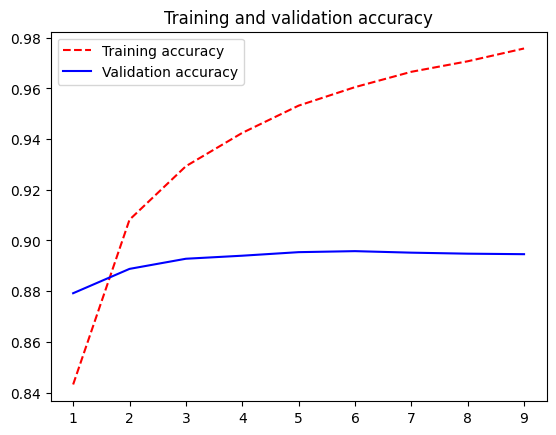

In [31]:
import matplotlib.pyplot as plt

accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
epochs = range(1, len(accuracy) + 1)

plt.plot(epochs, accuracy, "r--", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.show()

In [32]:
test_loss, test_acc = model.evaluate(bag_of_words_test_ds)
test_acc

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8868 - loss: 0.2808


0.8867599964141846

Let us do bigrams now!

In [33]:
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    # Learns a word-level vocabulary
    split="whitespace",
    output_mode="multi_hot",
    # Considers all unigrams and bigrams
    ngrams=2,
)
text_vectorization.adapt(train_ds_no_labels)

bigram_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bigram_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
bigram_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [34]:
model = build_linear_classifier(max_tokens, "bigram_classifier")
model.fit(
    bigram_train_ds,
    validation_data=bigram_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.8646 - loss: 0.3990 - val_accuracy: 0.8978 - val_loss: 0.3065
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9352 - loss: 0.2234 - val_accuracy: 0.9028 - val_loss: 0.2679


In [35]:
test_loss, test_acc = model.evaluate(bigram_test_ds)
test_acc

782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8967 - loss: 0.3085


0.8966799974441528

In [36]:
max_length = 600
max_tokens = 30_000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    # Learns a word-level vocabulary
    split="whitespace",
    # Outputs a integer sequence of token IDs
    output_mode="int",
    # Pads and truncates to 600 tokens
    output_sequence_length=max_length,
)
text_vectorization.adapt(train_ds_no_labels)

sequence_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
sequence_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)
sequence_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y), num_parallel_calls=8
)

In [37]:
x, y = next(sequence_test_ds.as_numpy_iterator())
x.shape

(32, 600)

In [38]:
x

array([[   29,     5,     2, ...,     0,     0,     0],
       [   56,    17,   954, ...,     0,     0,     0],
       [  269,   645,     8, ...,     0,     0,     0],
       ...,
       [    2, 11676,     3, ...,     0,     0,     0],
       [    2,  4114,     5, ...,     0,     0,     0],
       [   88,    80,    25, ...,     0,     0,     0]], shape=(32, 600))

In [39]:
from keras import ops

class OneHotEncoding(keras.Layer):
    def __init__(self, depth, **kwargs):
        super().__init__(**kwargs)
        self.depth = depth

    def call(self, inputs):
        # Flattens the inputs
        flat_inputs = ops.reshape(ops.cast(inputs, "int"), [-1])
        # Builds an identity matrix with all possible one-hot vectors
        one_hot_vectors = ops.eye(self.depth)
        # Uses our input token IDs to gather the correct vector for
        # each token
        outputs = ops.take(one_hot_vectors, flat_inputs, axis=0)
        # Unflattens the output
        return ops.reshape(outputs, ops.shape(inputs) + (self.depth,))

one_hot_encoding = OneHotEncoding(max_tokens)

In [40]:
x, y = next(sequence_train_ds.as_numpy_iterator())
one_hot_encoding(x).shape

(32, 600, 30000)

In [41]:
hidden_dim = 64
inputs = keras.Input(shape=(max_length,), dtype="int32")
x = one_hot_encoding(inputs)
x = layers.Bidirectional(layers.LSTM(hidden_dim))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs, name="lstm_with_one_hot")
model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

In [42]:
model.summary()

Model: "lstm_with_one_hot"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 600)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ one_hot_encoding                │ (None, 600, 30000)     │             0 │
│ (OneHotEncoding)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │    15,393,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,393,409 (58.72 MB)

 Trainable params: 15,393,409 (58.72 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.fit(
    sequence_train_ds,
    validation_data=sequence_val_ds,
    epochs=10,
    callbacks=[early_stopping],
)

Epoch 1/10
 10/625 ━━━━━━━━━━━━━━━━━━━━ 4:58:36 29s/step - accuracy: 0.4792 - loss: 0.6940

In [ ]:
test_loss, test_acc = model.evaluate(sequence_test_ds)
test_acc